In [1]:
import os
import pickle

In [2]:
final_model_path = "epoch199_WithClincal_03-08-2022 12-11-39"

In [3]:
# load testing.
with open(os.path.join("training_records", f"{final_model_path}.pkl"), 'rb') as f:
    training_record = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'training_records\\epoch199_WithClincal_03-08-2022 12-11-39.pkl'

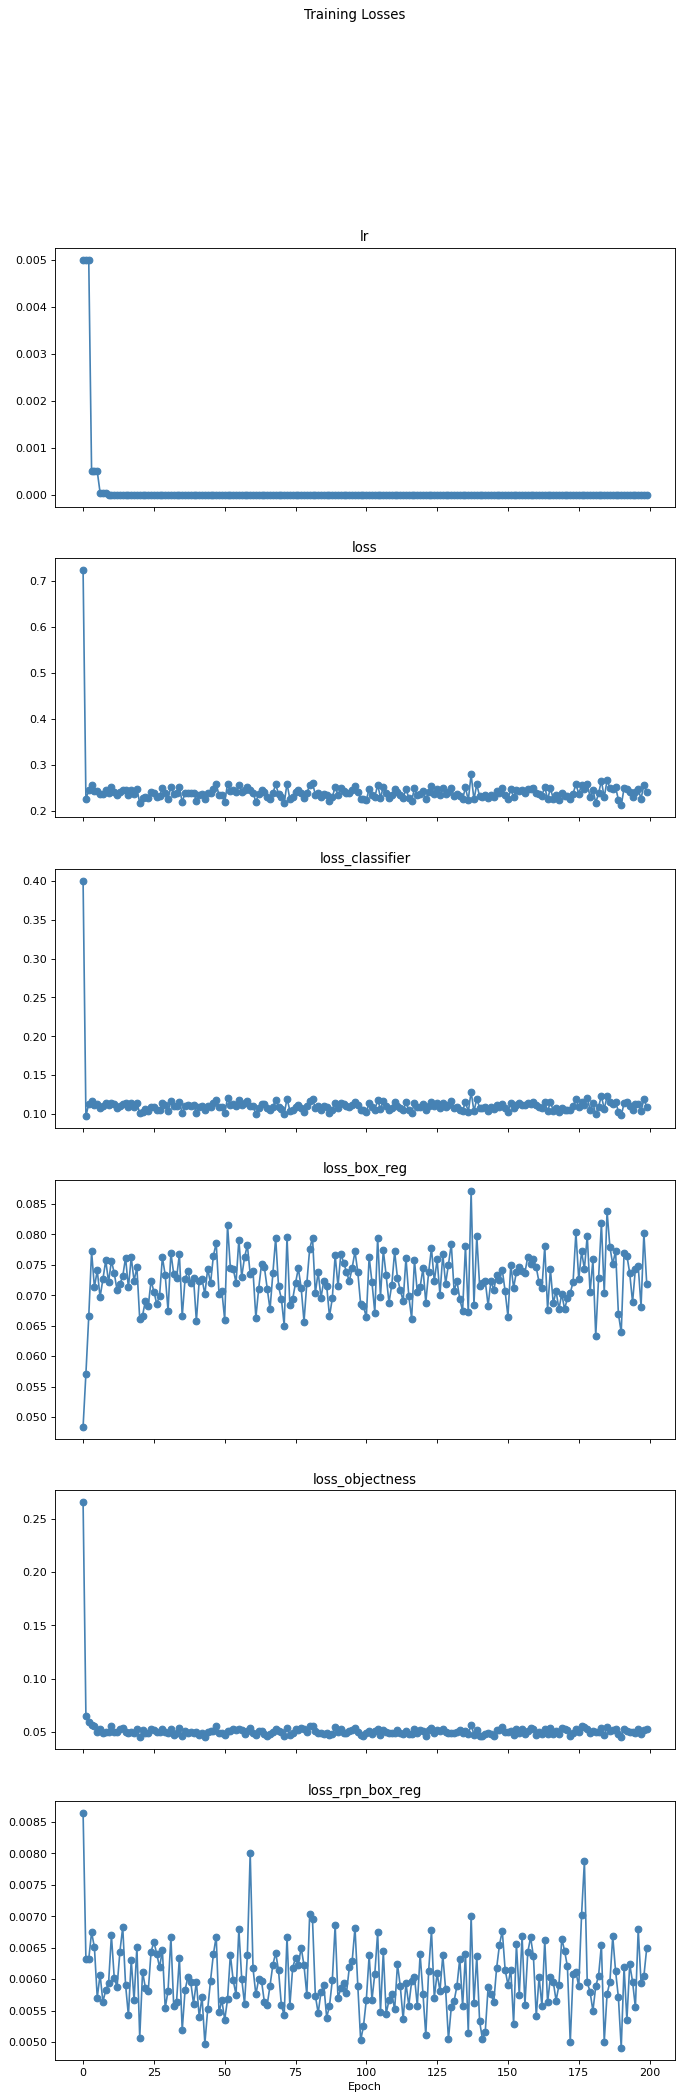

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

train_data_keys = training_record['train_data'][0].keys()

fig, subplots  = plt.subplots(
    len(train_data_keys), figsize=(10, 5* len(train_data_keys)), dpi=80, sharex=True)


fig.suptitle(f"Training Losses")

for i, k in enumerate(train_data_keys):
    subplots[i].set_title(k)
    subplots[i].plot([data[k] for data in training_record["train_data"]], marker='o', label=k, color='steelblue')
    # subplots[i].legend(loc="upper left")

subplots[-1].set_xlabel('Epoch')
plt.plot()
plt.pause(0.01)


In [5]:
test_evaluator = training_record['test_evaluator']

In [6]:
val_evaluators = training_record['val_evaluators']

In [7]:
val_evaluators[3].summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000


In [8]:
# let's load the model and do evaluation here.

In [9]:
import math
import sys
import time
import torch

from data.dataset import REFLACXWithClinicalAndBoundingBoxDataset
from utils.transforms import get_transform

XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"Will be using {device}")

Will be using cuda


In [10]:
## Prepare data
batch_size = 16

train_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="train",
    transforms=get_transform(train=True),
)

val_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="val",
    transforms=get_transform(train=False),
)

test_dataset = REFLACXWithClinicalAndBoundingBoxDataset(
    XAMI_MIMIC_PATH=XAMI_MIMIC_PATH,
    split_str="test",
    transforms=get_transform(train=False),
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)


val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=REFLACXWithClinicalAndBoundingBoxDataset.collate_fn
)



In [11]:
import torchvision
from models.rcnn import MultimodalFasterRCNN

## Weights of the first 2 layer of the ResNet backbone are fixed.
trainable_backbone_layers = torchvision.models.detection.backbone_utils._validate_trainable_layers(
    True, None, 5, 3
)
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone(
    "resnet50", pretrained=True, trainable_layers=trainable_backbone_layers
)
backbone.out_channels = 256


######################## For MobileNet backbone ########################
# from torchvision.models.detection.faster_rcnn import AnchorGenerator
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
# )
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=["0"], output_size=7, sampling_ratio=2
# )
########################################################################

model = MultimodalFasterRCNN(
    backbone,
    num_classes=len(train_dataset.labels_cols) + 1,
    rpn_anchor_generator=None,
    box_roi_pool=None,
    use_clinical=True, # Define whether we use clinical data in our model.
)

# move model to the right device
model.to(device)

MultimodalFasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
     

In [12]:
model.load_state_dict(torch.load(os.path.join('trained_models', final_model_path ), map_location=device))

<All keys matched successfully>

In [13]:
from utils.coco_utils import get_coco_api_from_dataset
from utils.coco_eval import CocoEvaluator

from utils import detect_utils

In [14]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [15]:
n_threads = torch.get_num_threads()
# FIXME remove this and make paste_masks_in_image run on the GPU
torch.set_num_threads(1)
cpu_device = torch.device("cpu")
model.eval()
metric_logger = detect_utils.MetricLogger(delimiter="  ")
header = "Test:"

coco = get_coco_api_from_dataset(test_dataloader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

for images, clinical_num, clinical_cat, targets in metric_logger.log_every(test_dataloader, 100, header):
    images = list(img.to(device) for img in images)
    clinical_num = [t.to(device) for t in clinical_num]
    clinical_cat = [t.to(device) for t in clinical_cat]

    torch.cuda.synchronize()
    model_time = time.time()
    outputs = model(images, (clinical_num, clinical_cat))

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    model_time = time.time() - model_time

    res = {
        target["image_id"].item(): output
        for target, output in zip(targets, outputs)
    }
    evaluator_time = time.time()
    coco_evaluator.update(res)
    evaluator_time = time.time() - evaluator_time
    metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

# gather the stats from all processes
metric_logger.synchronize_between_processes()
print("Averaged stats:", metric_logger)
coco_evaluator.synchronize_between_processes()

# accumulate predictions from all images
coco_evaluator.accumulate()
coco_evaluator.summarize()
torch.set_num_threads(n_threads)


c:\Users\mike8\Desktop\multimodal-abnormalities-detection\data\dataset.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxes_df[k] = ellipse_df[


creating index...
index created!


C:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Test:  [0/7]  eta: 0:01:02  model_time: 6.3576 (6.3576)  evaluator_time: 0.0130 (0.0130)  time: 8.8572  data: 2.1795  max mem: 7753
Test:  [6/7]  eta: 0:00:04  model_time: 0.5818 (1.5387)  evaluator_time: 0.0109 (0.0101)  time: 4.3121  data: 2.5247  max mem: 12375
Test: Total time: 0:00:30 (4.3128 s / it)
Averaged stats: model_time: 0.5818 (1.5387)  evaluator_time: 0.0109 (0.0101)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

In [51]:
anns = res 

In [56]:
anns[85]

{'boxes': tensor([[ 333.7211,    0.0000, 3056.0000, 2510.7610],
         [ 314.8852,    3.9789, 3056.0000, 2510.4277],
         [ 330.6593,   28.2428, 3056.0000, 2496.5024],
         [ 341.7241,    0.0000, 3029.1035, 2520.9922],
         [ 316.8096,    6.2413, 3056.0000, 2513.1465]],
        grad_fn=<ToCopyBackward0>),
 'labels': tensor([2, 3, 1, 5, 4]),
 'scores': tensor([0.0720, 0.0621, 0.0611, 0.0568, 0.0512], grad_fn=<ToCopyBackward0>)}

In [72]:
test_evaluator.coco_eval['bbox'].eval['precision']

array([[[[[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          [ 0.,  0.,  0.]],

        

In [16]:
image, clinical_num, clinical_cat, target =  train_dataset[2]

image = image.to(device)
clinical_num =  clinical_num.to(device)
clinical_cat = clinical_cat.to(device)

pred = model([image], ([clinical_num], [clinical_cat]))

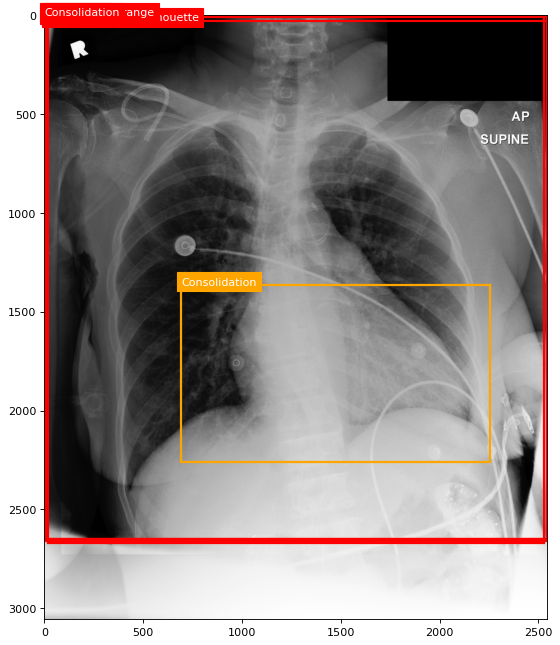

In [17]:
## Doesn't feel alright.
import PIL
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)

# load image
recs = []
for label, bbox in zip(pred[0]['labels'].detach().cpu().numpy(), pred[0]['boxes'].detach().cpu().numpy()):
    recs.append(Rectangle((bbox[0],bbox[1]), bbox[2] - bbox[0], bbox[3]-bbox[1], fill=False, color="red", linewidth=2))
    ax.text(bbox[0],bbox[1], train_dataset.label_index_to_disease(label),color="white", backgroundcolor="red")

for lable, bbox in zip(target['labels'].detach().cpu().numpy(),target['boxes'].detach().cpu().numpy()):
    recs.append(Rectangle((bbox[0],bbox[1]), bbox[2] - bbox[0], bbox[3]-bbox[1], fill=False, color="orange", linewidth=2))
    ax.text(bbox[0],bbox[1],train_dataset.label_index_to_disease(label), color="white",  backgroundcolor="orange")

for rec in recs:
    ax.add_patch(rec)

ax.imshow(PIL.Image.open(target['image_path']).convert("RGB"))


In [18]:
test_evaluator.coco_eval['bbox'].summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000


In [19]:
test_evaluator.coco_eval['bbox'].stats

array([ 0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.])

In [27]:
test_evaluator.coco_eval['bbox'].params.areaRngLbl

['all', 'small', 'medium', 'large']

In [30]:
p = test_evaluator.coco_eval['bbox'].params

In [31]:
aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == 'all']

In [32]:
mind = [i for i, mDet in enumerate(p.maxDets) if mDet == 100]

In [34]:
s = test_evaluator.coco_eval['bbox'].eval['precision']

In [35]:
s = s[:,:,:,aind,mind]

In [37]:
s.shape

(10, 101, 5, 1)

In [45]:
import numpy as np

mean_s = np.mean(s[s>-1])

In [75]:
test_evaluator.coco_eval['bbox'].